# Análise de sentimentos de tweets brasileiros nos períodos anterior e inicial da pandemia de Covid-19
***

<img style="float: left;" src="images/menu_resultados.png" width="800" height="500">

## IV - Análise dos resultados

Esta etapa apresenta uma **análise dos resultados obtidos** a partir dos **sentimentos de *tweets*** processados pela ferramenta VADER, procedimento realizado no passo anterior deste trabalho.

Serão apresentadas **totalizações de registros** e **quantitativo de registros por localizações** (cidades e estados). 

Para a análise dos sentimentos resultantes, são selecionadas as **100 cidades com maiores quantidades de *tweets***, de forma a englobar todas as capitais após a execução de todos filtros aplicados aos registros trabalhados. Tomando este recorte como base, são calculadas as médias de sentimentos nos intervalos anteriores e iniciais da pandemia de Covid-19. Estes intervalos foram divididos em **3 períodos**: **antes do primeiro caso de Covid-19**; **após o primeiro caso de Covid-19**; e **após a primeira morte por Covid-19**, para cada cidade selecionada.

Após esta seleção, são criados conjuntos com as cidades com **sentimentos mais negativos** e **sentimentos mais positivos**. Em cima desses conjuntos, são gerados **gráficos de médias de sentimentos por período**, **médias de sentimentos por dia** e de **palavras com maior ocorrência nas frases que mais influenciaram negativamente ou positivamente as médias de sentimentos**.

O intuito destas análises é observar eventuais **padrões comportamentais dos usuários nos diferentes períodos analisados, nos dois conjuntos de cidades observados**.

***
### Importações gerais

In [329]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from datetime import datetime
from datetime import timedelta

from statistics import mean

import warnings
warnings.filterwarnings('ignore')

### Configurações Iniciais

#### Conexão ao banco de dados

In [330]:
# Criando estrutura do banco de dados
from pymongo import MongoClient

# Conexão com o servidor do MongoDB
client = MongoClient('localhost', 27017)

# Conexão com a base de dados do mongoDB
db = client.SpedDB

# Coleção onde serão inseridos os dados
collection = db.tweets_brasil

#### Definição de variáveis

Nas células abaixo são definidas variáveis utilizadas no procedimento de análises de resultados.

A variável referente às *hashtags* armazena *strings* a serem desconsideradas nos gráficos de gerações de palavras, por serem palavras comuns ao universo dos registros presentes na base de dados (são, em maioria, *hashtags* utilizadas pelo GeoCoV19 para a coleta de *tweets*).

In [331]:
# Hashtags que serão desconsideradas nos items de processamentos de palavras pois são hashtags base que foram utilizados pelo GeoCov19 para seleção de todos os tweets (se repetem em todos os tweets)
default_hashtags = ['#coronavírus','#covid19','#covid2019','#covid19brasil','#covid2019brasil','#covid','#corona','#coronavirusbrasil', '#coronavirusnobrasil', '#coronavirus', '#covid-19', '#covidー19', '#covid_19', '#novocoronavírus']

# Número máximo de cidades de acordo com a quantidade de tweets
num_max_cidades = 100

# Número mínimo de dias por período analisado
min_num_days = 3

***
### Retornado resultados de tweets selecionados

Nos itens a seguir, é realizado o **carregamento dos registros com sentimentos processados** pelo VADER. Estes dados são carregados em um *dataframe*.

In [332]:
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [333]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 09:32:32,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
1,2020-02-02 09:33:28,user_location,São Paulo,Sorocaba,RT @revistasuper: #SuperLidas A doença surgiu ...,0.0000,pt
2,2020-02-02 09:34:20,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
3,2020-02-02 09:38:24,user_location,Paraíba,João Pessoa,RT @lelispatricia: Olavo de Carvalho é o “guru...,-0.4767,pt
4,2020-02-02 09:39:50,user_location,São Paulo,Conchas,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt


***
### Quantitativos de tweets a serem analisados

Nos item a seguir são apresentadas totalizações da base de registros que serão analisados e quantitativos por localizações (cidades e estados).

#### Quantidade total de tweets carregados

In [334]:
len(df)

1219385

#### Quantidade de *tweets* por estado

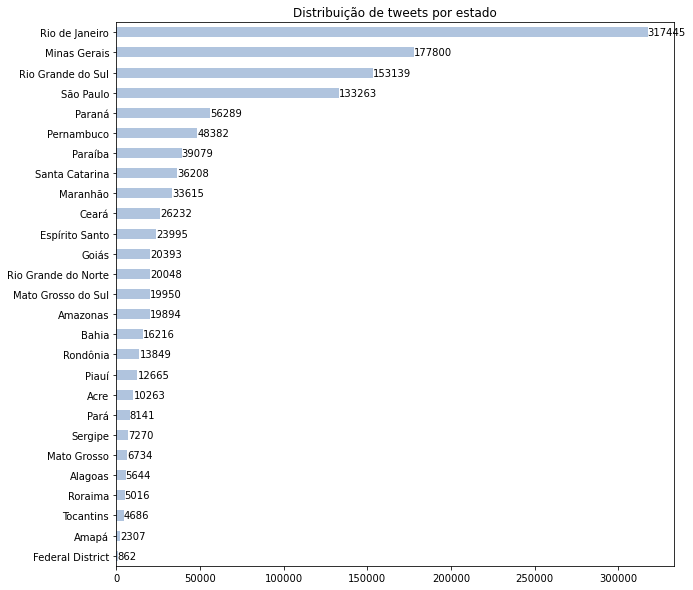

In [335]:
# Distribuição de tweets por estado
df.state.value_counts().sort_values().plot(kind='barh', figsize=(10, 10), title='Distribuição de tweets por estado', color='lightsteelblue')

for index, value in enumerate(df.state.value_counts().sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

#### Quantidade de *tweets* por cidade (100 maiores)

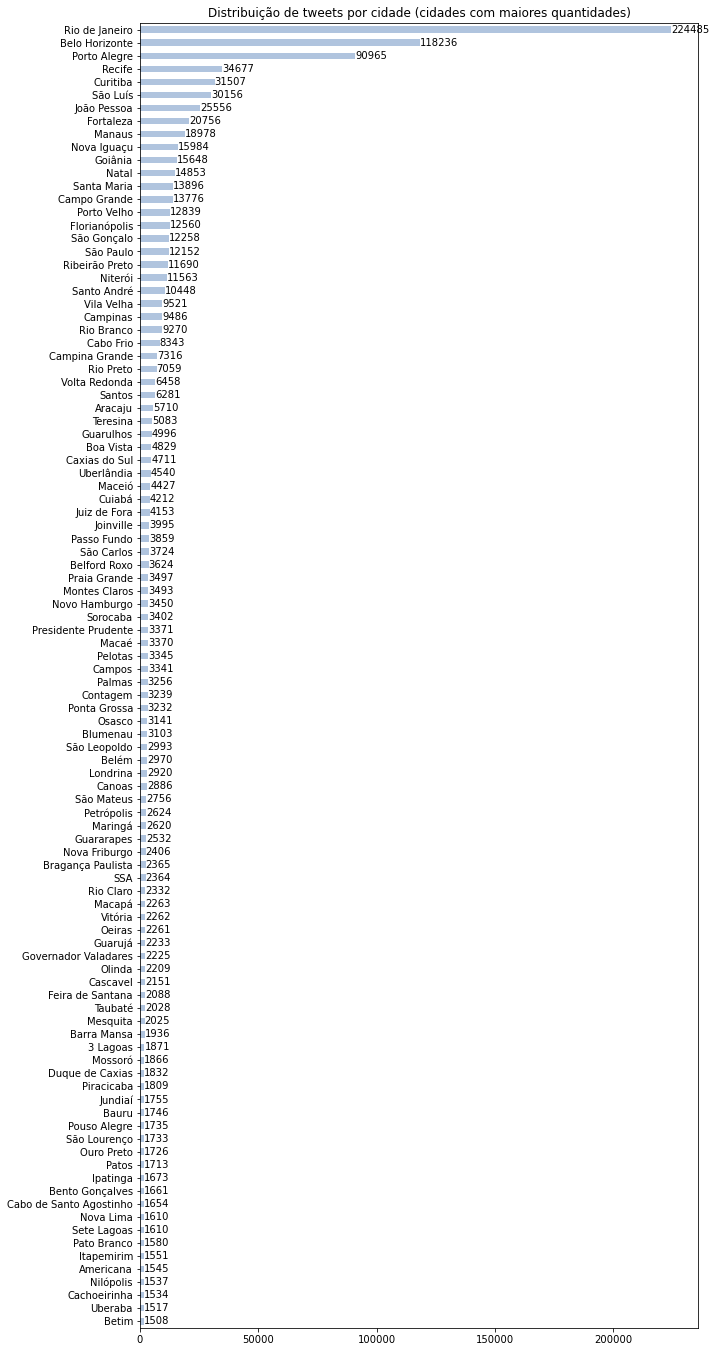

In [336]:
df_city = df.city.value_counts()[:num_max_cidades]

df_city.sort_values().plot(kind='barh', figsize=(10, 24), title='Distribuição de tweets por cidade (cidades com maiores quantidades)', color='lightsteelblue')

for index, value in enumerate(df_city.sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

***
### Processamento das análises de sentimentos por períodos

Neste ponto, serão iniciados os processamentos que fornecerão os **insumos** para a realização das **análises dos resultados dos sentimentos dos *tweets* nos 3 períodos analisados** (antes do primeiro caso, após o primeiro caso e após a primeia morte), para cada cidade.

#### Funções auxiliares para processamento de textos

As funções abaixo implementam procedimentos para processamento de textos que fornecerão saídas para as gerações de gráficos envolvendo a ocorrência de palavras em um dado conjunto de *tweets*.

A biblioteca ***NLTK*** foi utilizada para a realização de tarefas como tokenização e remoção de *stopwords*.

In [337]:
import nltk
import collections

from nltk.tokenize import TweetTokenizer
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime
from datetime import timedelta

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [338]:
def generate_tweets_tokens(texts):
        
    tokens = []
    
    hashtags_words = ['coronavíru','coronaviru','víru','viru','corona','coronavírus','coronavirus','virus','vírus','covid','covid19','covid-19', '19']
    words = ['’','“','','…','``','...','\'\'','t','https','http','co','rt','pra','pro','vc','pq','q','p','contra','tudo','sobre','aí','outro','tá','vai','ser','estar','está','to']
    stopwords = words + default_hashtags + hashtags_words + list(punctuation) + nltk.corpus.stopwords.words('portuguese')
    
    tweet_tokenizer = TweetTokenizer()
    
    for text in texts:        
        words = tweet_tokenizer.tokenize(text)
        for word in words:
            word.encode("ascii", errors="ignore").decode()      
            if word.lower() not in stopwords:
                tokens.append(word.lower())
   
    return tokens

In [339]:
def return_max_phrases_from_interval(df, start, end, max_res):
    
    top_words = []    
    df_query = df.loc[(df['score'] >= start) & (df['score'] < end)]

    phrases = list(df_query['text'])   
    counter = collections.Counter(phrases)
    
    return list(counter.most_common(max_res))

In [340]:
def return_tokens_from_interval(df, start, end):
    
    df_query = df.loc[(df['score'] > start) & (df['score'] < end)]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)
    
    return tokens

#### Funções auxiliares para geração de gráficos

In [341]:
def generate_bar_from_filtered_tokens(tokens, max_res, word_filter, color, x, y, title):
    
    hashtags = [word for word in tokens if word_filter in word and word not in default_hashtags]
    
    if len(hashtags) > 0:
        df_hashtags = pd.DataFrame(hashtags, columns = ['column'])
        df_hashtags['column'].value_counts().sort_values()[:max_res].plot(kind='barh', figsize=(x, y), color=color, title=title)

#### Funções auxiliares para manipulação de dataframes

Função para a montagem de *dataframe* contendo a média de *tweets* por data para um conjunto de *dataframe* de *tweets* informado.

#### Calculando datas de início e fim dos períodos

Nos itens a seguir são calculadas as datas de **primeiro caso de Covid-19** e **primeira morte por Covid-19** para cada cidade, dentre as 100 selecionadas. Estas datas serão utilizadas para a definição das datas de início e fim dos **3 períodos a serem analisados** (antes da primeiro caso, após o primeiro caso e após a primeira morte) para cada cidade, posteriormente.

Estas datas são **calculadas automaticamente** com a utilização de uma base de dados construída a partir dos **boletins das Secretarias Estaduais de Saúde(SES)**. Esta base possui informações de casos confirmados e óbitos, por data, para cada município (1).

Durante o cálculo de datas de início e fim de cada período, são **filtradas as cidades que possuem períodos de no mínimo 3 dias**, para minimizar o impacto de períodos muito curtos no cálculo da média de sentimentos por períodos.

O item a seguir **carrega o banco de dados com casos de Covid-19** a partir de um arquivo *CSV*:

In [342]:
# Carregando arquivo CSV contendo casos de Covid-19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

No passo adiante, ocorre a **seleção dos registros de casos de Covid-19 de municípios pertencentes ao conjunto das 100 maiores cidades** em quantidade de tweets:

In [343]:
top_cities = list(df.city.value_counts()[:num_max_cidades].index)
df_top_cities = df.loc[df['city'].isin(top_cities)]

No processamento abaixo ocorre o **cálculo das datas citadas** inicialmente para cada cidade.

In [344]:
cities = df_top_cities.groupby(['city','state'])

cities_cases_date = []
initial = '2020-02-01'
final = '2020-05-01'

for item, state in cities['city','state']:
    
    city = item[0]
    state = item[1]
    
    df_cases_city = df_cases_brasil.query('city == "'+city+'"')
    df_cases_city = df_cases_city.reset_index()
    df_cases_city = df_cases_city.drop(columns=['index'])
    
    if (len(df_cases_city) > 0):
    
        # Data do primeiro caso 
        first_case = df_cases_city.loc[0, 'date']

        # Data da primeira morte
        result = df_cases_city.query('last_available_deaths != "0"')
        
        if (len(result) > 0):
            first_death = df_cases_city.loc[min(result.index), 'date']
            
            initial_date = datetime.strptime(initial, '%Y-%m-%d')
            first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
            first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
            final_date = datetime.strptime(final, '%Y-%m-%d')
            
            total_days1 = (first_case_date - initial_date).days
            total_days2 = (first_death_date - first_case_date).days
            total_days3 = (final_date - first_death_date).days
            
            if (total_days1 > min_num_days and total_days2 > min_num_days and total_days3 > min_num_days):
                data = [city, state, first_case, first_death]
                cities_cases_date.append(data)

df_cities_cases_date = pd.DataFrame.from_dict(cities_cases_date)
df_cities_cases_date.columns = ['city', 'state', 'first_case_date', 'first_death_date']

O *dataframe* a seguir exibe um recorte dos registros com as colunas criadas contendo as datas calculadas no processamento realizado acima:

In [345]:
df_cities_cases_date.head()

,city,state,first_case_date,first_death_date
0,Americana,São Paulo,2020-03-31,2020-04-04
1,Aracaju,Sergipe,2020-03-14,2020-04-02
2,Barra Mansa,Rio de Janeiro,2020-03-05,2020-04-14
3,Bauru,São Paulo,2020-03-31,2020-04-05
4,Belford Roxo,Rio de Janeiro,2020-03-26,2020-04-02


Após este processamento, o número de cidades, **inicialmente em 100 registros, diminui para 69**. Como mostrado no código abaixo:

In [346]:
len(df_cities_cases_date)

69

In [347]:
df_cities_cases_date.columns

Index(['city', 'state', 'first_case_date', 'first_death_date'], dtype='object')

#### Processamento de dados por período

No processamento realizado a seguir ocorre a **geração de dados provenientes das análises de sentimentos e dos conteúdos dos *tweets*** das cidades selecionadas até então. Estes dados são processados **para cada cidade e para cada um dos 3 períodos analisados** (antes do primeiro caso, após o primeiro caso e após a primeira morte).

Os intervalos de datas referentes aos períodos citados são detalhados abaixo:

- **Primeiro Período**: Iniciando em 01/02/2020 (data do primeiro registro da base de dados) à data anterior ao primeiro caso de Covid-19 na cidade;
- **Segundo Período**: Iniciando na data do primeiro caso de Covid-19 na cidade à data anterior à primeira morte por Covid-19;
- **Terceiro Período**: Iniciando na data da primeira morte por Covid-19 na cidade à 01/05/2020 (data do último registro da base de dados)

Para cada um desses períodos, são gerados os seguintes dados que servirão de insumos para as análises realizadas mais adiante neste trabalho:

- **Média de *score* de sentimento total**;
- **Média de *score* de sentimento por período**;
- **Quantidade total de *tweets***;
- **Quantidade total de *tweets* por período**;
- **100 palavras com maior ocorrência em frases que mais influenciaram negativamente os *scores* de sentimentos**;
- **100 palavras com maior ocorrência em frases que mais influenciaram positivamente os *scores* de sentimentos**;

Durante este procedimento, ocorre a filtragem onde são consideradas somentes cidades que possuam no mínimo a quantidade de 300 *tweets* por período. Esta seleção ajuda a minimizar o impacto no cálculo da média de sentimentos para períodos com poucas quantidade de *tweets*.

In [348]:
def return_max_tokens_from_interval(df, start, end, max_tokens):
    
    top_words = []    
    df_query = df.loc[(df['score'] >= start) & (df['score'] < end)]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)
    counter = collections.Counter(tokens)
    
    return dict(counter.most_common(max_tokens))

In [349]:
# Quantidade mínima de tweets aceitáveis para cada período
min_tweets = 100

# Quantidade máxima de tokens a serem retornadas para cada frase analisada
max_tokens = 100

In [350]:
score_mean = []
score_mean_1 = []
score_mean_2 = []
score_mean_3 = []

qtd_tweets = []
qtd_tweets_1 = []
qtd_tweets_2 = []
qtd_tweets_3 = []

tokens_neg = []
tokens_neg_1 = []
tokens_neg_2 = []
tokens_neg_3 = []

tokens_pos = []
tokens_pos_1 = []
tokens_pos_2 = []
tokens_pos_3 = []

total_processed = 0

for index, row in df_cities_cases_date.iterrows():
    
    city = row['city']
    
    total_processed = total_processed + 1
    
    df_tweets = df.query('city == "'+city+'"')
    df_tweets_1 = df_tweets.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case+' 00:00:00"')  
    df_tweets_2 = df_tweets.query('created_at >= "'+first_case+' 00:00:00" and created_at < "'+first_death+' 00:00:00"')
    df_tweets_3 = df_tweets.query('created_at >= "'+first_death+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
    
    if (len(df_tweets_1) >= min_tweets and len(df_tweets_2) >= min_tweets and len(df_tweets_3) >= min_tweets):
        
        score_mean.append(mean(df_tweets['score']))        
        score_mean_1.append(mean(df_tweets_1['score']))
        score_mean_2.append(mean(df_tweets_2['score']))
        score_mean_3.append(mean(df_tweets_3['score']))
    
        start = df_tweets['score'].describe()['min']
        end = df_tweets['score'].describe()['25%']

        tokens_city_neg = return_max_tokens_from_interval(df_tweets, start, end, max_tokens)
        tokens_city_neg_1 = return_max_tokens_from_interval(df_tweets_1, start, end, max_tokens)
        tokens_city_neg_2 = return_max_tokens_from_interval(df_tweets_2, start, end, max_tokens)
        tokens_city_neg_3 = return_max_tokens_from_interval(df_tweets_3, start, end, max_tokens)

        tokens_neg.append(tokens_city_neg)
        tokens_neg_1.append(tokens_city_neg_1)
        tokens_neg_2.append(tokens_city_neg_2)
        tokens_neg_3.append(tokens_city_neg_3)

        start = df_tweets['score'].describe()['75%']
        end = df_tweets['score'].describe()['max']

        tokens_city_pos = return_max_tokens_from_interval(df_tweets, start, end, max_tokens)
        tokens_city_pos_1 = return_max_tokens_from_interval(df_tweets_1, start, end, max_tokens)
        tokens_city_pos_2 = return_max_tokens_from_interval(df_tweets_2, start, end, max_tokens)
        tokens_city_pos_3 = return_max_tokens_from_interval(df_tweets_3, start, end, max_tokens)

        tokens_pos.append(tokens_city_pos)
        tokens_pos_1.append(tokens_city_pos_1)
        tokens_pos_2.append(tokens_city_pos_2)
        tokens_pos_3.append(tokens_city_pos_3)
        
        qtd_tweets.append(len(df_tweets))
        qtd_tweets_1.append(len(df_tweets_1))
        qtd_tweets_2.append(len(df_tweets_2))
        qtd_tweets_3.append(len(df_tweets_3))
        
    else:
        df_cities_cases_date = df_cities_cases_date.drop(index)
        
    print(total_processed,'processado(s)')
    
df_cities_cases_date['score_mean'] = score_mean
df_cities_cases_date['score_mean_1'] = score_mean_1
df_cities_cases_date['score_mean_2'] = score_mean_2
df_cities_cases_date['score_mean_3'] = score_mean_3

df_cities_cases_date['tokens_neg'] = tokens_neg
df_cities_cases_date['tokens_neg_1'] = tokens_neg_1
df_cities_cases_date['tokens_neg_2'] = tokens_neg_2
df_cities_cases_date['tokens_neg_3'] = tokens_neg_3

df_cities_cases_date['tokens_pos'] = tokens_pos
df_cities_cases_date['tokens_pos_1'] = tokens_pos_1
df_cities_cases_date['tokens_pos_2'] = tokens_pos_2
df_cities_cases_date['tokens_pos_3'] = tokens_pos_3

df_cities_cases_date['qtd_tweets'] = qtd_tweets
df_cities_cases_date['qtd_tweets_1'] = qtd_tweets_1
df_cities_cases_date['qtd_tweets_2'] = qtd_tweets_2
df_cities_cases_date['qtd_tweets_3'] = qtd_tweets_3

1 processado(s)
2 processado(s)
3 processado(s)
4 processado(s)
5 processado(s)
6 processado(s)
7 processado(s)
8 processado(s)
9 processado(s)
10 processado(s)
11 processado(s)
12 processado(s)
13 processado(s)
14 processado(s)
15 processado(s)
16 processado(s)
17 processado(s)
18 processado(s)
19 processado(s)
20 processado(s)
21 processado(s)
22 processado(s)
23 processado(s)
24 processado(s)
25 processado(s)
26 processado(s)
27 processado(s)
28 processado(s)
29 processado(s)
30 processado(s)
31 processado(s)
32 processado(s)
33 processado(s)
34 processado(s)
35 processado(s)
36 processado(s)
37 processado(s)
38 processado(s)
39 processado(s)
40 processado(s)
41 processado(s)
42 processado(s)
43 processado(s)
44 processado(s)
45 processado(s)
46 processado(s)
47 processado(s)
48 processado(s)
49 processado(s)
50 processado(s)
51 processado(s)
52 processado(s)
53 processado(s)
54 processado(s)
55 processado(s)
56 processado(s)
57 processado(s)
58 processado(s)
59 processado(s)
60 pro

Recorte do *dataframe* contendo os dados gerados para cada cidade e cada período realizados acima:

In [351]:
df_cities_cases_date.head()

,city,state,first_case_date,first_death_date,score_mean,score_mean_1,score_mean_2,score_mean_3,tokens_neg,tokens_neg_1,tokens_neg_2,tokens_neg_3,tokens_pos,tokens_pos_1,tokens_pos_2,tokens_pos_3,qtd_tweets,qtd_tweets_1,qtd_tweets_2,qtd_tweets_3
1,Aracaju,Sergipe,2020-03-14,2020-04-02,-0.050649,-0.031442,-0.029884,-0.057509,"{'brasil': 151, 'bolsonaro': 99, 'casos': 85, ...","{'brasil': 17, 'agora': 16, 'gripe': 15, 'pess...","{'bolsonaro': 9, 'dois': 5, 'país': 5, 'hospit...","{'brasil': 133, 'bolsonaro': 80, 'casos': 75, ...","{'casos': 165, 'brasil': 139, '️': 82, 'matéri...","{'brasil': 21, 'governo': 16, 'aqui': 16, 'saú...","{'brasil': 7, 'parabéns': 6, 'pode': 6, 'presi...","{'casos': 154, 'brasil': 111, '️': 78, 'matéri...",5710,1297,194,4219
4,Belford Roxo,Rio de Janeiro,2020-03-26,2020-04-02,0.004392,0.004702,-0.018114,0.006053,"{'brasil': 54, 'morrer': 54, 'gente': 52, 'mãe...","{'morrer': 25, 'nunca': 23, 'gente': 22, 'agor...","{'todo': 7, 'mundo': 6, 'quarentena': 5, 'medo...","{'brasil': 35, 'mãe': 30, 'gente': 26, '😭': 26...","{'deus': 80, '🤣': 75, '😂': 64, 'amor': 61, 'ca...","{'paulo': 42, 'resto': 42, 'país': 41, 'ningué...","{'deus': 8, 'calma': 7, 'ainda': 7, 'casa': 6,...","{'deus': 61, '🤣': 51, 'amor': 48, '🙌': 42, 'em...",3624,1451,168,2005
5,Belo Horizonte,Minas Gerais,2020-03-16,2020-03-30,-0.046808,-0.021647,-0.032389,-0.057984,"{'brasil': 2479, 'bolsonaro': 2046, 'pessoas':...","{'brasil': 432, 'gente': 432, 'causa': 389, 'c...","{'bolsonaro': 142, 'brasil': 95, 'pessoas': 87...","{'brasil': 1952, 'bolsonaro': 1581, 'mortos': ...","{'brasil': 1853, 'agora': 1247, 'dia': 1223, '...","{'país': 431, 'gente': 389, 'brasil': 388, 'ni...","{'deus': 121, 'casa': 117, 'tô': 115, 'preside...","{'brasil': 1418, 'agora': 942, 'dia': 923, 'ca...",118236,32924,4885,80427
6,Belém,Pará,2020-03-18,2020-04-06,-0.050234,-0.009508,-0.069118,-0.062154,"{'😭': 77, 'pessoas': 65, 'casa': 65, 'ainda': ...","{'brasil': 12, 'pessoas': 10, 'faz': 10, 'gent...","{'bolsonaro': 5, 'vou': 4, 'matar': 4, 'toda':...","{'😭': 72, 'casa': 55, 'pessoas': 53, 'gente': ...","{'pessoas': 53, 'deus': 51, 'gente': 45, 'bom'...","{'bom': 12, 'quarentena': 11, '😂': 11, 'deus':...","{'4': 4, 'brasil': 4, '1': 3, '2': 3, 'quarent...","{'pessoas': 41, 'deus': 40, 'gente': 33, '️': ...",2970,689,125,2156
7,Boa Vista,Roraima,2020-03-21,2020-04-03,-0.032256,-0.003825,-0.069267,-0.043530,"{'casos': 84, 'roraima': 81, 'brasil': 72, 'pe...","{'gente': 20, 'agora': 19, 'brasil': 18, 'comb...","{'leitos': 16, 'doou': 10, 'outros': 9, 'saúde...","{'casos': 71, 'roraima': 66, 'pessoas': 64, 'c...","{'casos': 124, 'casa': 93, 'agora': 85, 'boa':...","{'casa': 44, 'boa': 43, 'casos': 41, '2': 36, ...","{'😂': 7, 'trabalhar': 5, 'r': 4, '😘': 4, 'part...","{'casos': 81, 'agora': 73, 'confirmados': 57, ...",4829,1517,225,3087


Após o processamento, o número de cidades consideradas para análise **diminuiu de 69 para 50 cidades**, como visto no código abaixo:

In [352]:
len(df_cities_cases_date)

50

***
### Resultados obtidos

Os itens a seguir apresentam gráficos e métricas estatísticas de forma a auxiliar a interpretação dos resultados decorrente dos dados gerados a partir dos conteúdos dos *tweets* das cidades analisados, para cada período analisado.

**Gráficos de cidades com menores e maiores médias de *scores de sentimentos***

10 cidades com **menores médias de *scores*** de sentimentos

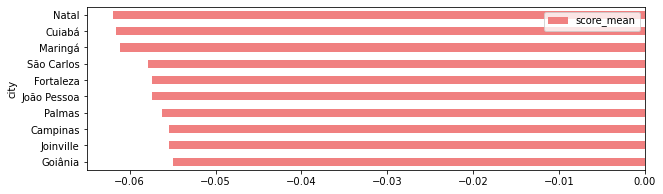

In [353]:
df_cities_neg = df_cities_cases_date.sort_values(by=['score_mean'], ascending=True)[:10]
df_cities_neg.sort_values(by=['score_mean'], ascending=False).plot(kind='barh', x='city', y='score_mean', figsize=(10, 3), color='lightcoral')

10 cidades com **maiores médias de *scores* de sentimentos**

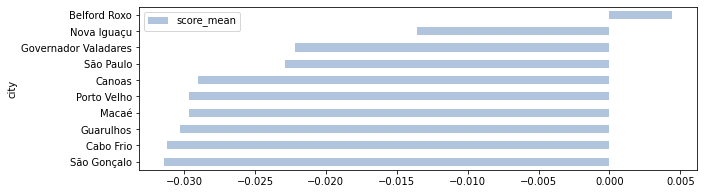

In [379]:
df_cities_pos = df_cities_cases_date.sort_values(by=['score_mean'], ascending=False)[:10]
df_cities_pos.sort_values(by=['score_mean'], ascending=True).plot(kind='barh', x='city', y='score_mean', figsize=(10, 3), color='lightsteelblue')

***
**Boxplots**

10 cidades com **menores médias de *scores* de sentimentos**

In [355]:
df_cities_neg['score_mean'].describe()

count    10.000000
mean     -0.057929
std       0.002663
min      -0.061920
25%      -0.060287
50%      -0.057419
75%      -0.055624
max      -0.054979
Name: score_mean, dtype: float64

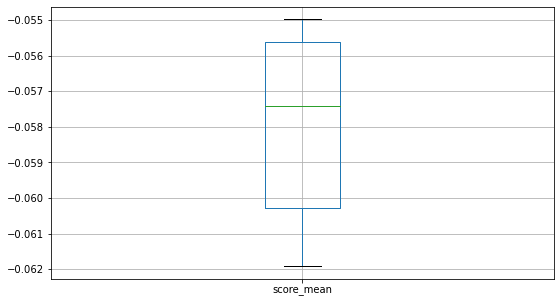

In [356]:
boxplot = df_cities_neg.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

10 cidades com **maiores médias de *scores* de sentimentos**

In [357]:
df_cities_pos['score_mean'].describe()

count    10.000000
mean     -0.023543
std       0.011318
min      -0.031394
25%      -0.030147
50%      -0.029322
75%      -0.022361
max       0.004392
Name: score_mean, dtype: float64

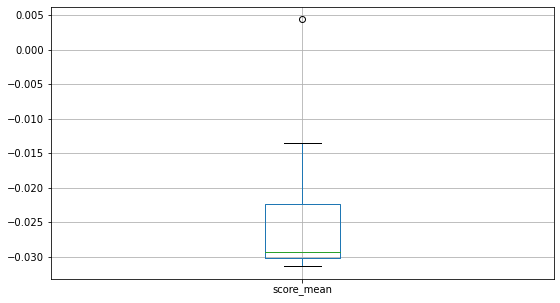

In [358]:
boxplot = df_cities_pos.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

**Notas**

De acordo com as métricas obtidas acima:
- Os *scores* das 10 cidades com **menores médias** de sentimentos **variam de -0.061920 a -0.054979**, com **média de -0.057929**.
- Os *scores* das 10 cidades com **maiores médias** de sentimentos **variam de -0.031394 a 0.004392**, com **média de -0.023543**.

Observa-se que os dois conjuntos analisados possuem **médias de *scores* de sentimentos negativos e bem próximos a zero**. O que pode ser um indicativo de **neutralidade** em relação aos sentimentos de *tweets* dos conjuntos analisados. 

***
**Gráfico de Barras**

*Funções auxiliares*

In [359]:
def generate_cities_means_bars(df):
    
    bar_width = 0.25

    means_1 = list(df['score_mean_1'])
    means_2 = list(df['score_mean_2'])
    means_3 = list(df['score_mean_3'])

    # Cria eixo x para produto A e produto B com uma separação de 0.25 entre as barras
    x1 =  np.arange(len(means_1))
    x2 = [x + bar_width for x in x1]
    x3 = [x + bar_width for x in x2]

    # Plota as barras
    plt.bar(x1, means_1, width=bar_width, label = 'Antes do 1º caso', color = 'moccasin')
    plt.bar(x2, means_2, width=bar_width, label = 'Após o 1º caso', color = 'sandybrown')
    plt.bar(x3, means_3, width=bar_width, label = 'Após a 1ª morte', color = 'indianred')

    # coloca o nome dos meses como label do eixo x
    cities = list(df['city'])
    plt.xticks([x + bar_width for x in range(len(means_1))], cities)

    # inseri uma legenda no gráfico
    plt.legend()

    plt.title("Médias de scores de sentimentos por período")
    plt.show()

Cidades com **menores médias** de sentimentos

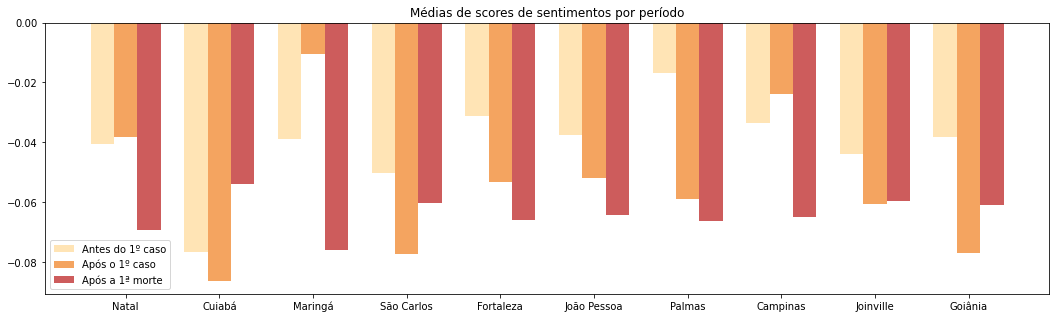

In [360]:
generate_cities_means_bars(df_cities_neg)

Cidades com **maiores médias** de sentimentos

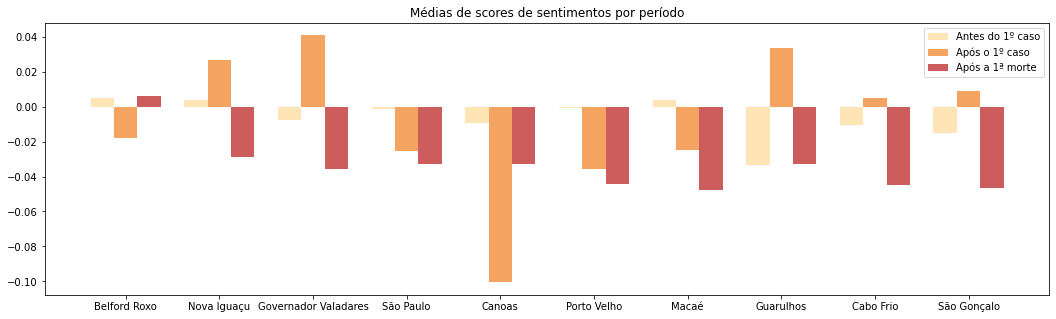

In [361]:
generate_cities_means_bars(df_cities_pos)

**Média de *scores* de sentimento por dia**

*Funções utilizadas na geração dos gráficos*

In [362]:
def generate_cities_means_lines(df, df_cities, title):
    
    df_cities = df_cities.reset_index()
    
    cities = list(df_cities['city'])   
    colors = ['lightgrey','lightsalmon','steelblue','tan','mediumseagreen','lightpink','lightgreen','tomato','plum','gold']
    fig, ax = plt.subplots()
    
    date_list = list(pd.to_datetime(df['created_at']).dt.date.unique())
      
    for index, row in df_cities.iterrows():
        
        df_scores = df.loc[df['city'] == row['city']]
        df_dates = building_dates_df(df_scores, date_list, 'score')   
        
        x = date_list
        y = df_dates.score_mean
        
        first_case_date_str = row['first_case_date']
        first_case_date = datetime.strptime(first_case_date_str, '%Y-%m-%d')
        
        first_death_date_str = row['first_death_date']
        first_death_date = datetime.strptime(first_death_date_str, '%Y-%m-%d')
        
        plt.axvline(first_case_date, color='crimson')
        plt.axvline(first_death_date, color='black')
       
        ax.plot(x, y, color=colors[index], linestyle='solid', linewidth=2, label=row['city'])
        
    ax.grid()
    ax.margins(0)

    plt.rcParams['figure.figsize'] = (18,5)
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel('Datas',fontsize=15)
    plt.ylabel('Médias',fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.show()

In [363]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, date_list, column):

    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        
        try:
            # Média de scores do período
            score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
            score_mean_list.append(score_mean)
        except:
            score_mean_list.append(0)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

Cidades com **menores médias** de sentimentos

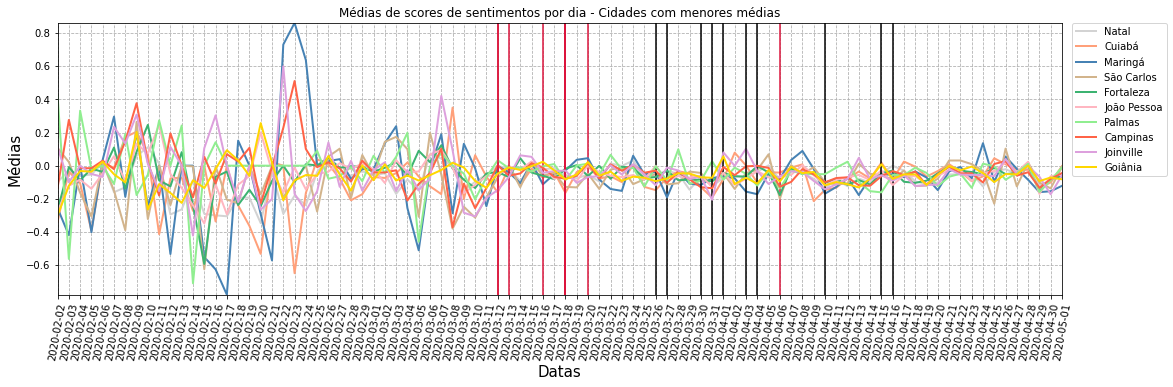

In [364]:
generate_cities_means_lines(df, df_cities_neg, 'Médias de scores de sentimentos por dia - Cidades com menores médias')

Cidades com **maiores médias** de sentimentos

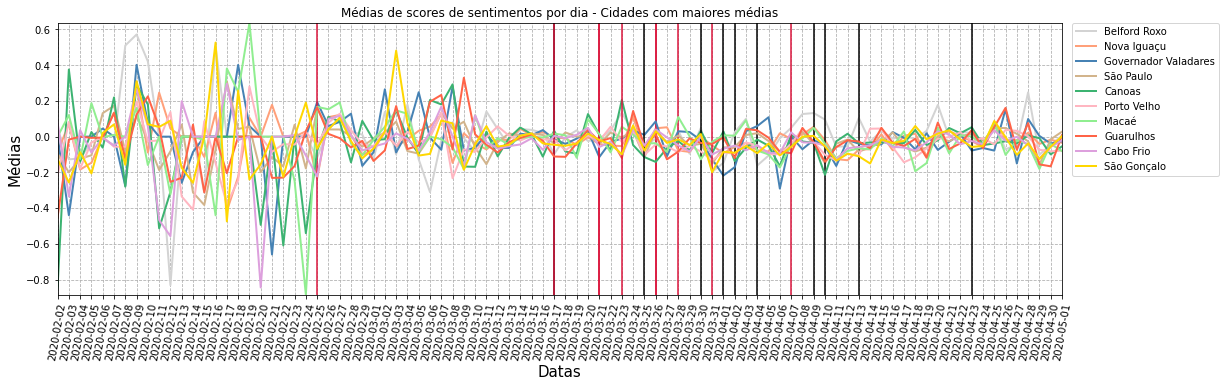

In [365]:
generate_cities_means_lines(df, df_cities_pos, 'Médias de scores de sentimentos por dia - Cidades com maiores médias')

**Palavras presentes nos tweets que mais influenciaram negativamente/positivamente**

*Funções utilizadas para gerações de gráficos*

In [465]:
def return_tokens_freq(dicts, max_res):
    
    final = Counter({})    
    for tokens_dict in dicts: 
        final = Counter(final) + Counter(tokens_dict)
                
    return dict(final.most_common(max_res))

In [466]:
def generate_bar_from_tokens_freq(dicts, max_res, color, x, y, title):
    
    tokens_freq = return_tokens_freq(dicts, max_res)
    df_words = pd.DataFrame().from_dict(tokens_freq, orient='index', columns=['total'])
    df_words = df_words.sort_values(by = ['total'], ascending=[False])
    df_words = df_words[:max_res]
    df_words.sort_values(by = ['total'], ascending=[True]).plot(kind='barh', figsize=(x, y), color=color, title=title)

In [467]:
def generate_cloud_from_tokens_freq(dicts, max_res, color):
    
    tokens_freq = return_tokens_freq(dicts, max_res)
    wordcloud = WordCloud(background_color=color, max_words=100, normalize_plurals=False).generate_from_frequencies(tokens_freq)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [468]:
max_bars_words = 5
max_clouds_words = 100

neg_back_cloud_color = 'mistyrose'
pos_back_cloud_color = 'aliceblue'

neg_back_bar_color = 'lightcoral'
pos_back_bar_color = 'lightsteelblue'

Primeiro Período (Antes do 1º caso)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **negativamente**

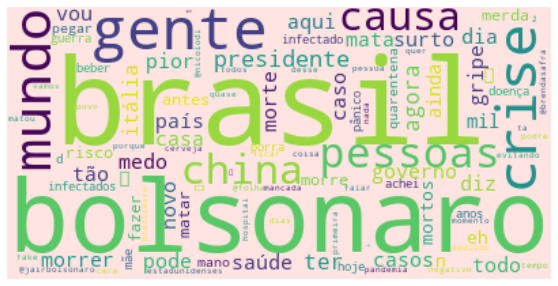

In [469]:
generate_cloud_from_tokens_freq(df_cities_neg['tokens_neg_1'], max_clouds_words, neg_back_cloud_color)

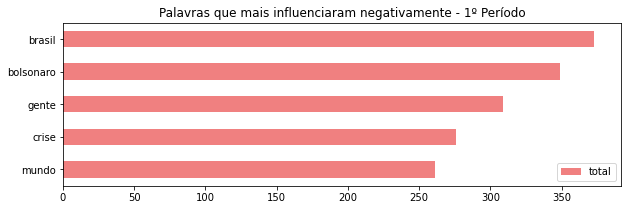

In [470]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
generate_bar_from_tokens_freq(df_cities_neg['tokens_neg_1'], max_bars_words, neg_back_bar_color, 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **negativamente**

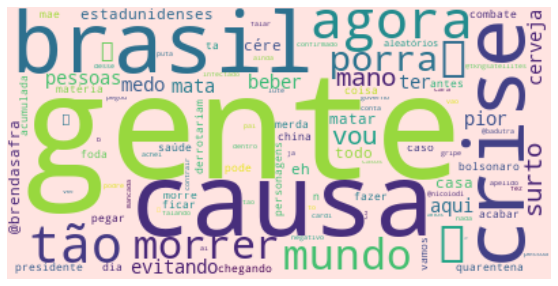

In [471]:
generate_cloud_from_tokens_freq(df_cities_pos['tokens_neg_1'], max_clouds_words, neg_back_cloud_color)

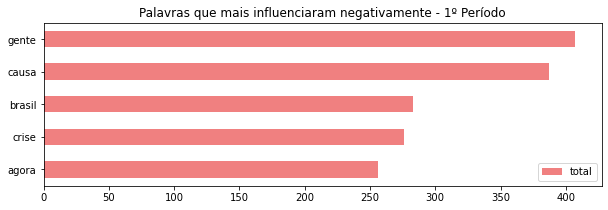

In [475]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
generate_bar_from_tokens_freq(df_cities_pos['tokens_neg_1'], max_bars_words, neg_back_bar_color, 10, 3, title)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **positivamente**

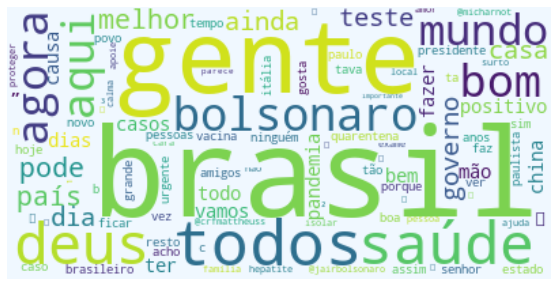

In [476]:
generate_cloud_from_tokens_freq(df_cities_neg['tokens_pos_1'], max_clouds_words, pos_back_cloud_color)

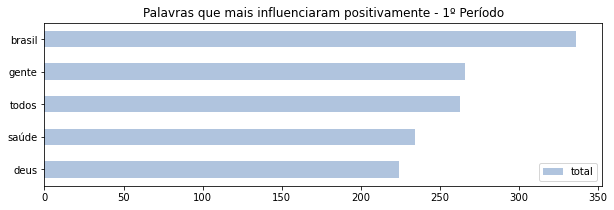

In [503]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
generate_bar_from_tokens_freq(df_cities_neg['tokens_pos_1'], max_bars_words, pos_back_bar_color, 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **positivamente**

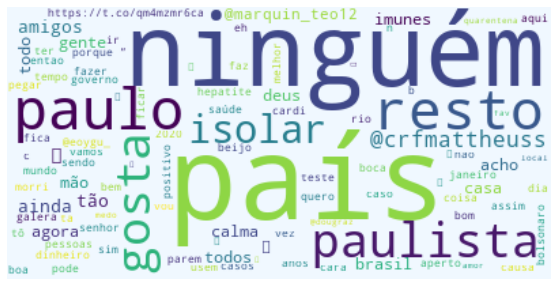

In [479]:
generate_cloud_from_tokens_freq(df_cities_pos['tokens_pos_1'], max_clouds_words, pos_back_cloud_color)

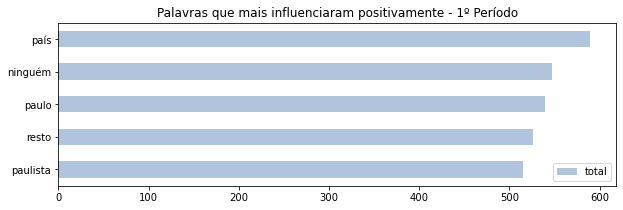

In [502]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
generate_bar_from_tokens_freq(df_cities_pos['tokens_pos_1'], max_bars_words, pos_back_bar_color, 10, 3, title)

Segundo Período (Após 1º caso)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **negativamente**

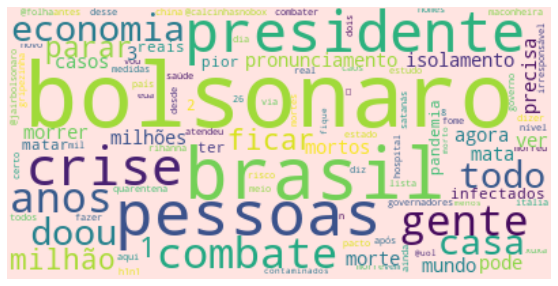

In [481]:
generate_cloud_from_tokens_freq(df_cities_neg['tokens_neg_2'], max_clouds_words, neg_back_cloud_color)

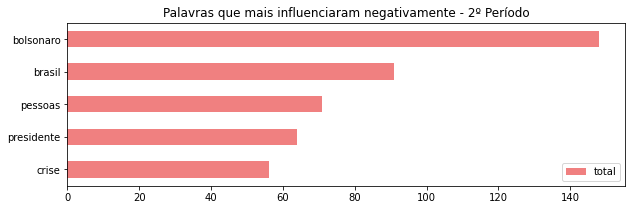

In [482]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
generate_bar_from_tokens_freq(df_cities_neg['tokens_neg_2'], max_bars_words, neg_back_bar_color, 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **negativamente**

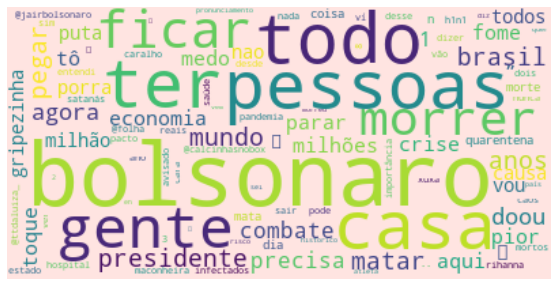

In [483]:
generate_cloud_from_tokens_freq(df_cities_pos['tokens_neg_2'], max_clouds_words, neg_back_cloud_color)

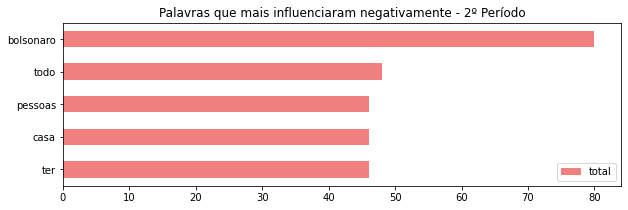

In [484]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
generate_bar_from_tokens_freq(df_cities_pos['tokens_neg_2'], max_bars_words, neg_back_bar_color, 10, 3, title)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **positivamente**

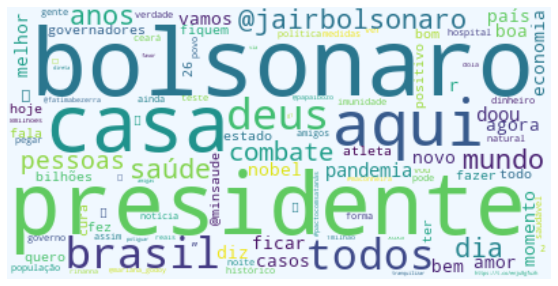

In [485]:
generate_cloud_from_tokens_freq(df_cities_neg['tokens_pos_2'], max_clouds_words, pos_back_cloud_color)

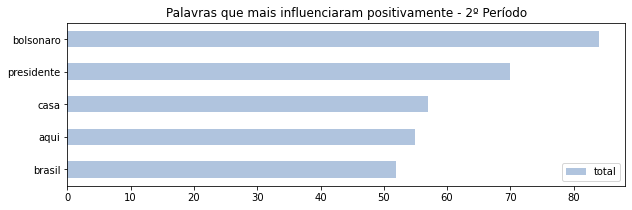

In [488]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
generate_bar_from_tokens_freq(df_cities_neg['tokens_pos_2'], max_bars_words, pos_back_bar_color, 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **positivamente**

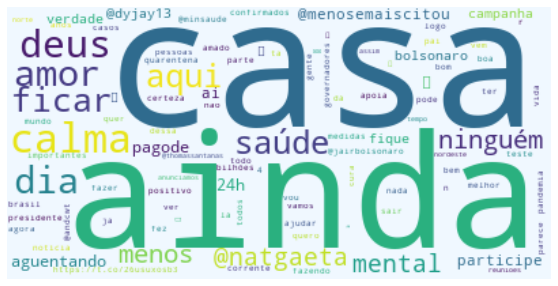

In [489]:
generate_cloud_from_tokens_freq(df_cities_pos['tokens_pos_2'], max_clouds_words, pos_back_cloud_color)

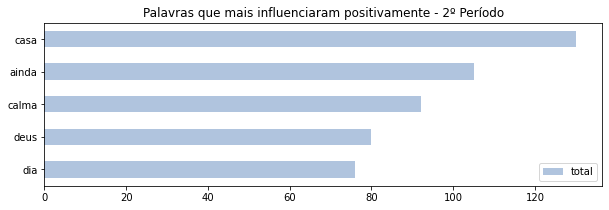

In [501]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
generate_bar_from_tokens_freq(df_cities_pos['tokens_pos_2'], max_bars_words, pos_back_bar_color, 10, 3, title)

Terceiro Período (Após 1ª morte)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **negativamente**

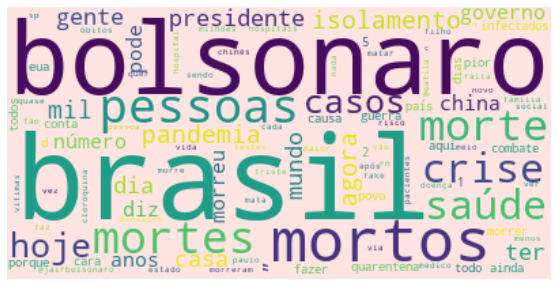

In [491]:
generate_cloud_from_tokens_freq(df_cities_neg['tokens_neg_3'], max_clouds_words, neg_back_cloud_color)

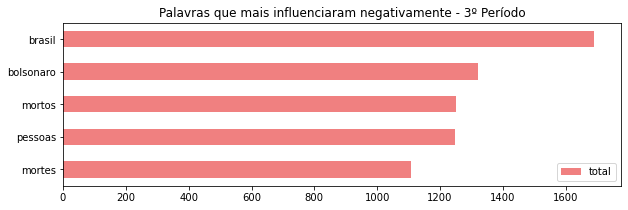

In [492]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
generate_bar_from_tokens_freq(df_cities_neg['tokens_neg_3'], max_bars_words, neg_back_bar_color, 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **negativamente**

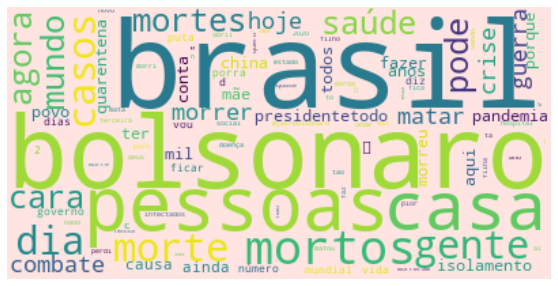

In [493]:
generate_cloud_from_tokens_freq(df_cities_pos['tokens_neg_3'], max_clouds_words, neg_back_cloud_color)

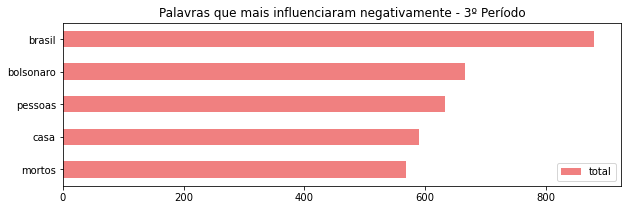

In [494]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
generate_bar_from_tokens_freq(df_cities_pos['tokens_neg_3'], max_bars_words, neg_back_bar_color, 10, 3, title)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **positivamente**

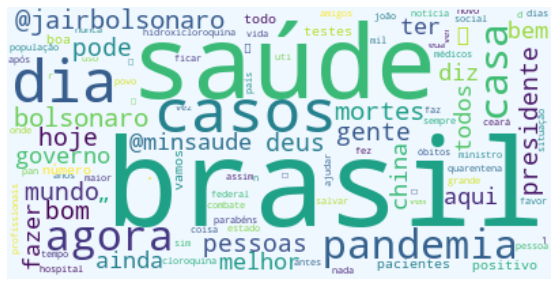

In [495]:
generate_cloud_from_tokens_freq(df_cities_neg['tokens_pos_3'], max_clouds_words, pos_back_cloud_color)

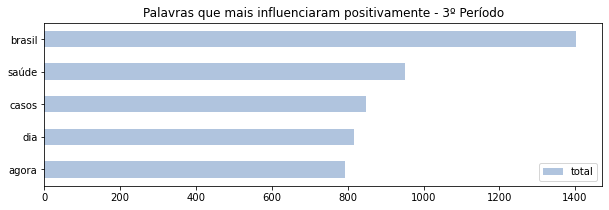

In [497]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
generate_bar_from_tokens_freq(df_cities_neg['tokens_pos_3'], max_bars_words, pos_back_bar_color, 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **positivamente**

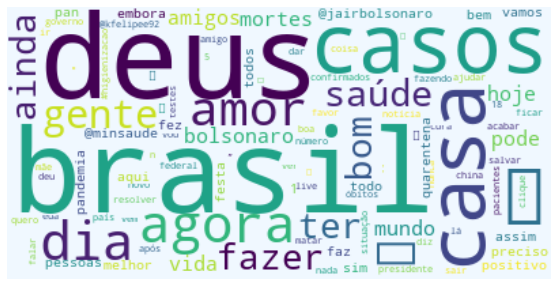

In [498]:
generate_cloud_from_tokens_freq(df_cities_pos['tokens_pos_3'], max_clouds_words, pos_back_cloud_color)

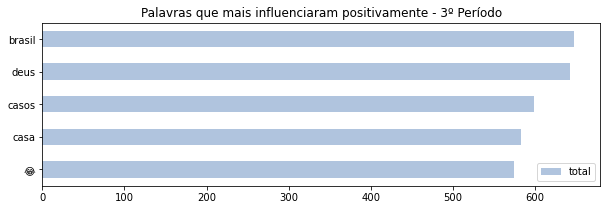

In [500]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
generate_bar_from_tokens_freq(df_cities_pos['tokens_pos_3'], max_bars_words, pos_back_bar_color, 10, 3, title)

***
### Fontes

(1) Brasil.io - Boletins informativos e casos do coronavírus por município por dia -https://brasil.io/dataset/covid19/caso_full/